<center>

# **📘 Patent Classification - Task 1**



</center>

In this notebook, we explore the task of **patent classification**, a multi-class document classification problem where the objective is to automatically assign an abstract from patent document to one of several predefined **technology categories** following the Cooperative Patent Classification Scheme (CPC).


- We will begin by understanding the problem context, surveying the current state of the art, and examining the dataset in detail. 
- We will then establish simple baselines—including a random and a rule-based classifier—to set reference points for future model evaluation.


### **Outline**
---


1. [🔧 Load and Preview Dataset](#part1)
2. [📊 Dataset Description](#part1)  
3. [🎲 Random Classifier Benchmark](#part1)
4. [📏 Rule-Based Classifier](#part1)  
5. [🧩 Summary and Key Observations](#part1)




In [61]:
from utils import Metrics
from datasets import load_dataset, DatasetDict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math
from collections import Counter
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from staticvectors import StaticVectors
from tqdm import tqdm

from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from staticvectors import StaticVectors
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
#plot confussion matrix for the test set
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from staticvectors import StaticVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.feature_selection import chi2


palette = sns.color_palette("Spectral", 9)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# **1. Load the Dataset**

We will use the `ccdv/patent-classification` dataset from the Hugging Face Hub, which contains **35,000 U.S. patents abstracts**, including both their full texts and abstracts, annotated with **classification labels**. Each patent is assigned to one of **nine distinct technical categories** based on its content.

This dataset is derived from the **BIGPATENT** corpus, which was originally constructed for summarization tasks. It contains full-text patent documents and human-written summaries sourced from the **Google Patents Public Datasets** via BigQuery (Google, 2018). While BIGPATENT was primarily intended for abstractive summarization, in this study we repurpose it for the task of **patent classification** using just the summaries.


In [62]:
dataset = load_dataset("ccdv/patent-classification", "abstract")
df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

Why having 3 dataset is benefitial for our model?

Using three datasets (train, val, test) helps prevent overfitting and ensures better generalization. The val set allows tuning and model selection without leaking information from the test set.


# **2. Dataset Description**
---
This section aims to provide a brief overview of our dataset, including size, class distribution, and any peculiar characteristics. 

### **Distribution of labels**

Let's see the distribution of the labels in the datasets, to know if we are dealing with a balanced dataset or not, and based on that taking into account which metric should be the adecuate the evaluate the performance of the model.


In [63]:
label_map = {
    '0': "Human Needs",
    '1': "Operations & Transport",
    '2': "Chemistry & Metallurgy",
    '3': "Textiles & Paper",
    '4': "Construction",
    '5': "Mechanical & Thermal Engineering",
    '6': "Physics",
    '7': "Electricity",
    '8': "Cross-Tech Tagging"
}
df_train['label_name'] = df_train['label'].astype(str).map(label_map)
df_val['label_name'] = df_val['label'].astype(str).map(label_map)
df_test['label_name'] = df_test['label'].astype(str).map(label_map)

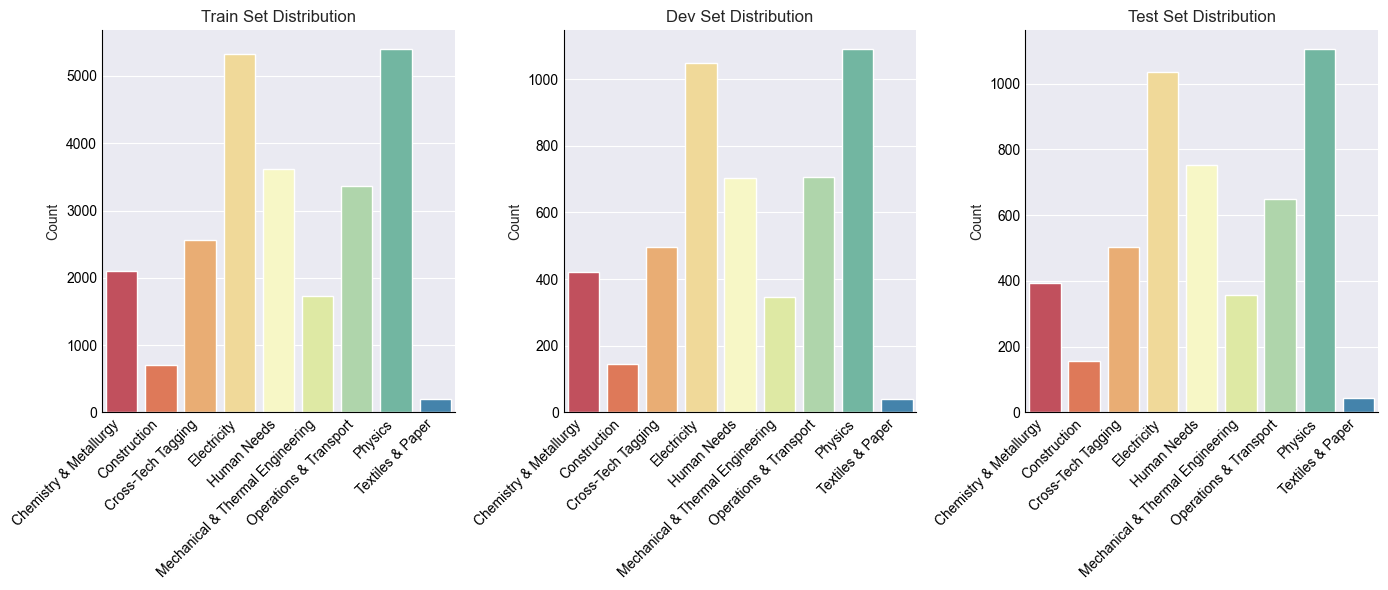

In [64]:
# Step 1: Define consistent order of labels
label_order = sorted(set(df_train['label_name']) | set(df_val['label_name']) | set(df_test['label_name']))

# Step 2: Create a consistent color palette
palette_colors = sns.color_palette("Spectral", n_colors=len(label_order))
palette_dict = dict(zip(label_order, palette_colors))

# Step 3: Plot with consistent order and palette
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

for i, (df, label) in enumerate(zip([df_train, df_val, df_test], ['Train', 'Dev', 'Test'])):
    sns.countplot(
        data=df,
        x='label_name',
        hue='label_name',
        ax=axs[i],
        order=label_order,
        palette=palette_dict,
        legend=False
    )
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
    axs[i].set_title(f'{label} Set Distribution')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    # Style spines
    axs[i].spines['bottom'].set_color('black')
    axs[i].spines['left'].set_color('black')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    # Style ticks
    axs[i].tick_params(axis='y', colors='black', direction='in', length=5, width=1)
    axs[i].tick_params(axis='x', colors='black', direction='in', length=5, width=1)

plt.tight_layout()
plt.show()


By visualizing the number of samples per class across the training, validation, and test sets, we observe a clear **class imbalance**. Categories such as `Physics`, `Electricity`, `Human Needs`, and `Operations & Transport` appear far more frequently than underrepresented ones like `Textiles & Paper` or `Cross-Tech Tagging`.

This imbalance is expected in the context of patent literature. Technologically dynamic areas—such as electronics, energy, and healthcare—naturally generate more patent filings. In contrast, domains like textiles or construction tend to evolve more slowly or have a narrower scope, contributing fewer documents to the dataset.

As discussed by Benzineb and Guyot (2011) in *Current Challenges in Patent Information Retrieval*[1], patent classes often follow a **Pareto-like distribution**, where **a small number of categories cover the vast majority of documents**.

In such imbalanced datasets, using **accuracy** as the main metric can be misleading. A model could predict only the majority classes and still achieve high accuracy, while performing poorly on minority ones.

Instead, we evaluate model performance using:

* **Macro F1-score** – gives equal weight to each class, making it sensitive to minority performance.
* **Micro F1-score** – aggregates contributions across all classes, favoring performance on more frequent classes.

Together, these metrics provide a more nuanced understanding of classifier behavior under class imbalance.

---

> [1]: Benzineb, K., & Guyot, J. (2011). Automated patent classification. In *Current Challenges in Patent Information Retrieval* (pp. 239–261). Springer. [https://doi.org/10.1007/978-3-642-19231-9\_12](https://doi.org/10.1007/978-3-642-19231-9_12)




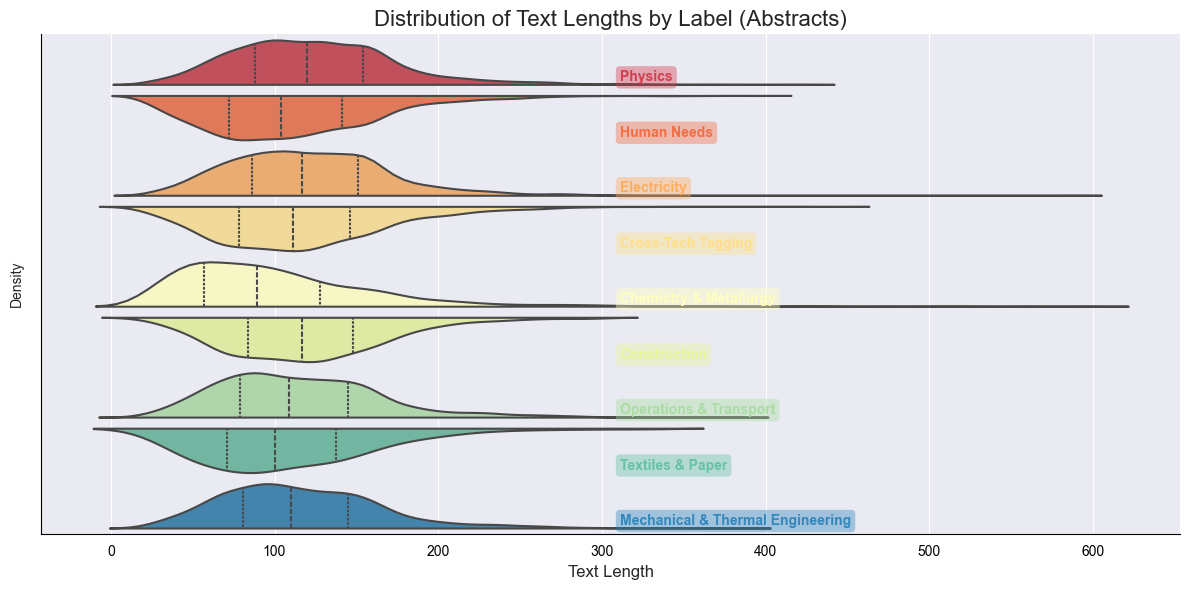

In [65]:
#generate text_lenght column for abstracts
df_train["text_lenght"] = df_train["text"].apply(lambda x: len(x.split()))
df_train['text_lenght'] = pd.to_numeric(df_train['text_lenght'], errors='coerce')

# Create plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    data=df_train,
    y="label_name",
    x="text_lenght",
    inner="quartile",
    palette="Spectral",
    fill=True,
    linewidth=1.5,
    split=True,
    hue="label_name"
)

y_labels = df_train['label_name'].unique()
y_ticks = range(len(y_labels))

colors = sns.color_palette("Spectral", len(y_labels))

for y, label, color in zip(y_ticks, y_labels, colors):
    ax.text(
        x=df_train['text_lenght'].median()+200,  # Horizontal placement, you can adjust
        y=y+0.4,
        s=label,
        ha='left',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color=color,
        bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3', alpha=0.4)
    )
#hide the y axis
ax.set_yticklabels([])
ax.set_ylabel('Density')
ax.set_xlabel('Text Length', fontsize=12)
ax.set_title('Distribution of Text Lengths by Label (Abstracts)', fontsize=16)
# Style spines
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Style ticks
ax.tick_params(axis='y', colors='black', direction='out', length=5, width=1)
ax.tick_params(axis='x', colors='black', direction='out', length=5, width=1)

plt.tight_layout()
plt.show()


As expected, the distributions are **right-skewed** across all classes, with some abstract documents reaching lengths of up to **600 tokens**.

We observe that:

- The median text length across classes is fairly consistent—around **120 words**—indicating a strong central tendency.
- Classes such as <code>Chemistry & Metallurgy</code>, <code>Electricity</code>, <code>Physics</code>, and <code>Human Needs</code> tend to have longer abstracts, likely due to their technical complexity and detailed domain-specific descriptions.

While using abstracts simplifies the classification task by mitigating issues related to input length and token limitation, it also introduces new challenges. Abstracts may lack the full **vocabulary diversity** present in complete documents, and their **summarized language** could oversimplify nuanced terms that are critical for distinguishing between classes—potentially reducing the model’s ability to capture **discriminative vocabulary signals**.

In the following cells, we explore this limitation in more detail.

In [66]:
# ============ Cleaning functions ============
def remove_special_characters(text):
    text = re.sub(r'[^A-Za-z\s]', '', text.lower())
    return text

def remove_stopwords_tokenize(text, stop_words_set):
    text = [word for word in text.split() if word not in stop_words_set and len(word) > 1]
    return text

def get_clean_tokens_list(texts, stop_words_set):
    all_words = []
    for txt in texts:
        txt = remove_special_characters(txt)
        txt = remove_stopwords_tokenize(txt, stop_words_set)
        all_words.extend(txt)
    return all_words

# ============ Plot function ============
def plot_wordclouds_by_class(df, stop_words_set, text_column='text', label_column='label', label_name_column='label_name', cmap='Spectral'):
    unique_labels = sorted(df[label_column].unique())
    n_classes = len(unique_labels)

    cols = 3
    rows = (n_classes + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5))
    axs = axs.flatten()

    for i, label in enumerate(unique_labels):
        texts = df[df[label_column] == label][text_column].values
        tokens = get_clean_tokens_list(texts, stop_words_set)
        # Convert list of tokens to frequency dict
        token_freq = dict(Counter(tokens))

        wc = WordCloud(width=800, height=250, background_color='white', colormap=cmap, random_state=42).generate_from_frequencies(token_freq)

        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].axis('off')

        label_name = df[df[label_column] == label][label_name_column].iloc[0]
        axs[i].set_title(label_name, fontsize=14)

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout(pad=0.01)
    plt.show()

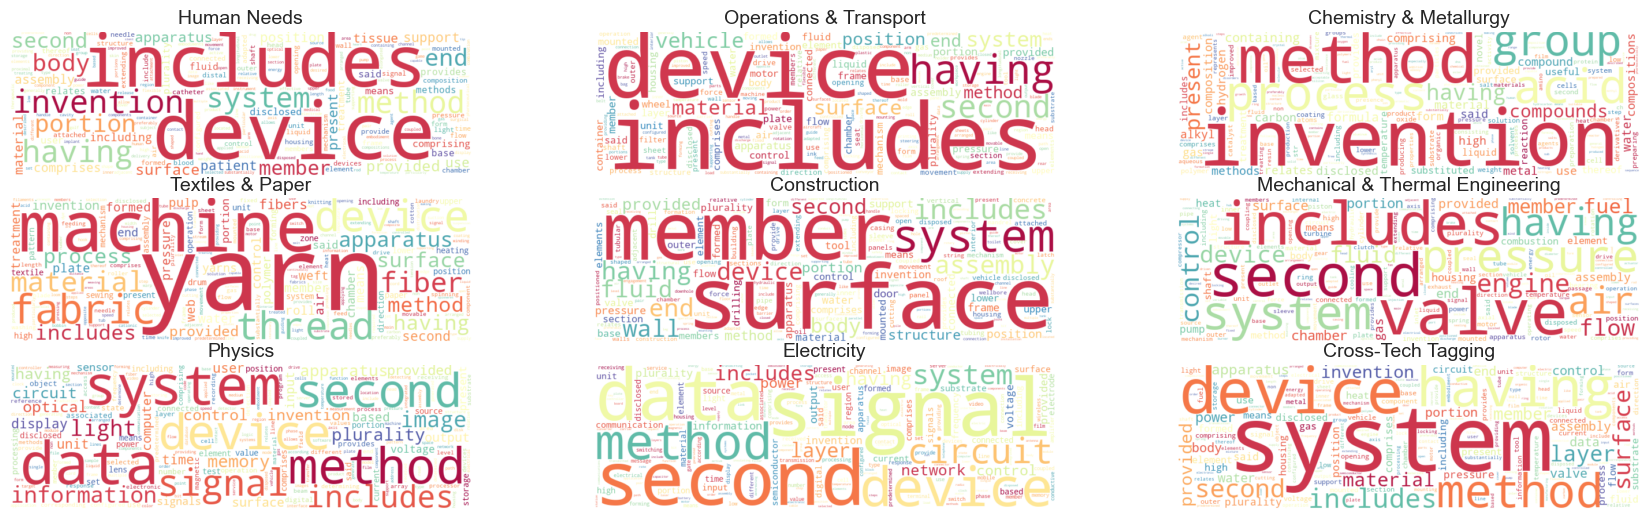

In [67]:
stop_words = set(spacy_stopwords)
plot_wordclouds_by_class(df_train, stop_words)


Analyzing the word clouds above reveals that the vocabulary across all patent classes contains many generic patent-specific terms (e.g., <code>invention</code>, <code>include</code>,  <code>member</code>, <code>device</code>). These terms are common across patent documents regardless of their technical domain and thus provide little discriminative power for classifying patents into their respective categories.

In the next cell, we will create a set of generic patent-related words that appear frequently across all classes but don't provide meaningful discriminative information. By removing these words along with the standard stop words, we expect that it will be possible to highlight the domain-specific terminology that characterizes each patent class.


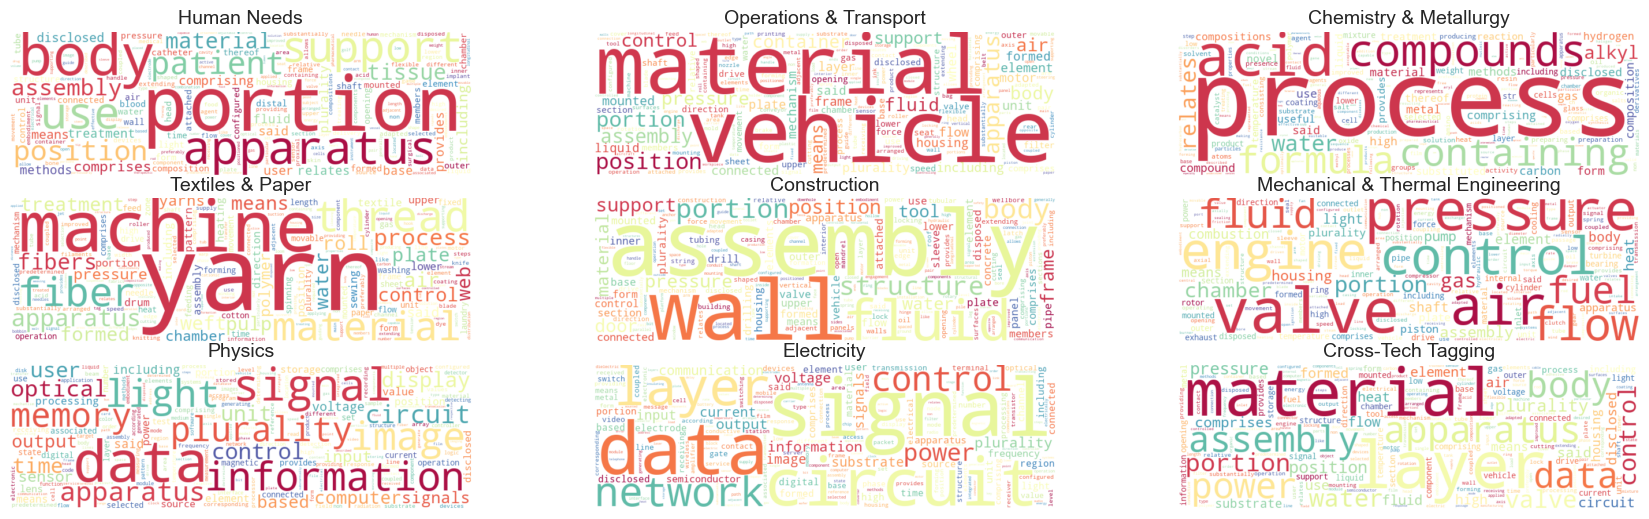

In [68]:
generic_words_patents = {"includes","include","invention", "device", "system",
                         "provided", "provide", "fabric", "example", "shown",
                         "method", "second", "having", 'end', "group", "member", "surface", "member", "present"}
plot_wordclouds_by_class(df_train, stop_words.union(generic_words_patents))

We can observe that even with simple preprocessing, some clear patterns begin to emerge:

- Chemistry & Metallurgy: Characterized by terms such as <code>acid</code>, <code>process</code>, <code>formula</code>, and <code>ml</code>, which are directly related to chemical processes.

- Textiles & Paper: This category shows a particularly distinct vocabulary, with frequent words like <code>yarn</code>, <code>fiber</code>, and <code>thread</code>.

- Construction: Common terms in this category include <code>wall</code>, <code>assembly</code>, <code>structure</code>, and <code>fluid</code>, all relevant to construction and engineering contexts.

- Electricity: We find words such as <code>circuit</code>, <code>layer</code>, <code>signal</code>, and <code>network</code>, which are typical of electrical and electronic fields.

- Mechanical & Thermal Engineering: Includes terms like <code>engine</code>, <code>pressure</code>, <code>control</code>,<code>valve</code>, <code>fuel</code>, and <code>gas</code>, which are characteristic of this discipline.

- Operation & Transport: Includes <code>vehicle</code> as one of the most frequent term that is accurate for the category. However, it also contains many commonly shared terms across other categories, suggesting that this class may be less discriminative, potentially making it harder to separate during classification.

- Cross-Tech Tagging: This category shares a substantial portion of its vocabulary with other classes, indicating low lexical uniqueness. As a result, it is likely to be one of the most challenging categories to predict, due to the lack of distinctive or category-specific terminology.

In the remaining categories, while some terms are clearly related to their specific domain, many words appear across multiple categories, which may introduce ambiguity for a classification model. For example, words such as <code>system</code>, <code>data</code>, <code>material</code> are present in the majority of categories and may confuse the model when assigning labels to patent texts.

## **TF-IDF**

When analyzing the top 10 terms per label using TF-IDF, use the <code>max_df</code> parameter to automatically filter out generic verbs and terms used in the abstract, appart from the ones in <code>generic_words_patents</code> that will be removed manually. We limit the vocabulary to the top 1000, so we can capture the nuanced and discriminative terms that will help the model separate the classes. Both <code>unigrams</code> and <code>bigrams</code> are considered. Additionally, we dont apply <code>min_df</code>, taking into account that patent texts often include rare or domain-specific terminology, and we dont want to get rid off from this low frequency words. This is important because patents frequently use highly technical language, and descriptions are often deliberately complex—either to avoid plagiarism or to obscure similarities with existing inventions—making rare terms potentially decisive for accurate classification.

| Parameter              | Value                                          | Comment                                                                           |
| ---------------------- | ---------------------------------------------- | --------------------------------------------------------------------------------- |
| `max_df=0.7`           | Excludes overly common terms (in >70% of docs) | ✅ Helps remove noise and generic terms                                            |
| `max_features=1000`    | Limits vocabulary to top 1000 terms by TF-IDF  | ✅ Controls sparsity but keeping industry unique words                                     |
| `ngram_range=(1,2)`    | Includes unigrams and bigrams                  | ✅ Critical for domain-specific phrases like `"electric field"` or `"fiber optic"` |
| `stop_words='english'` | Removes basic functional words                 | ✅ Prevents TF-IDF weight from being wasted on non-informative terms               |


In [107]:
# --- TF-IDF Vectorization ---
#remove the generic_words_patents from the text
def remove_generic_words_patents(text):
    return ' '.join([word for word in text.split() if word not in generic_words_patents])

corpus = df_train["text"].apply(remove_special_characters).apply(remove_generic_words_patents)
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, ngram_range=(1,2), max_df=0.7)
X = vectorizer.fit_transform(corpus)
features = np.array(vectorizer.get_feature_names_out())
y = df_train['label']
label_map_int = {int(k): v for k, v in label_map.items()}

# --- Top TF-IDF Terms by Class ---
tfidf_df = pd.DataFrame(X.toarray(), columns=features)
tfidf_df["label"] = y
keywords_per_class = {}

TOP_N = 10

for label in y.unique():
    mean_tfidf = tfidf_df[tfidf_df["label"] == label].drop(columns="label").mean()
    top_keywords = mean_tfidf.sort_values(ascending=False).head(TOP_N)
    label_name = label_map_int[label]
    keywords_per_class[label_name] = top_keywords.index.tolist()

keywords_df = pd.DataFrame.from_dict(keywords_per_class, orient="index").T.reset_index(drop=True)
keywords_df

,Physics,Human Needs,Electricity,Cross-Tech Tagging,Chemistry & Metallurgy,Construction,Operations & Transport,Textiles & Paper,Mechanical & Thermal Engineering
0,data,body,signal,material,compounds,assembly,vehicle,machine,valve
1,signal,portion,data,layer,acid,wall,material,fibers,engine
2,image,patient,circuit,water,process,fluid,container,fiber,pressure
3,information,use,layer,assembly,formula,structure,position,process,air
4,light,tissue,network,power,relates,body,portion,material,fuel
5,memory,treatment,power,body,containing,door,apparatus,web,fluid
6,optical,composition,information,apparatus,compound,water,assembly,apparatus,flow
7,apparatus,relates,communication,valve,compositions,tool,air,paper,gas
8,user,methods,voltage,pressure,composition,support,pressure,air,chamber
9,display,apparatus,semiconductor,disclosed,novel,frame,support,water,pump


Each column corresponds to a patent category, and each row shows a top TF-IDF-ranked word or bigram for that class.

The top keywords mostly align very well with domain expectations, which suggests that the TF-IDF setup is successfully isolating discriminative, domain-specific vocabulary for most classes.

However, some terms like <code>data</code>, <code>signal</code>, <code>air</code>, <code>information</code> are present in most of the classes and some of them like <code>Cross-Tech Tagging</code> have more generic or shared terms ("power", "material", "apparatus"), which is expected — category is more abstract or broad.  

Loading Word2Vec model...


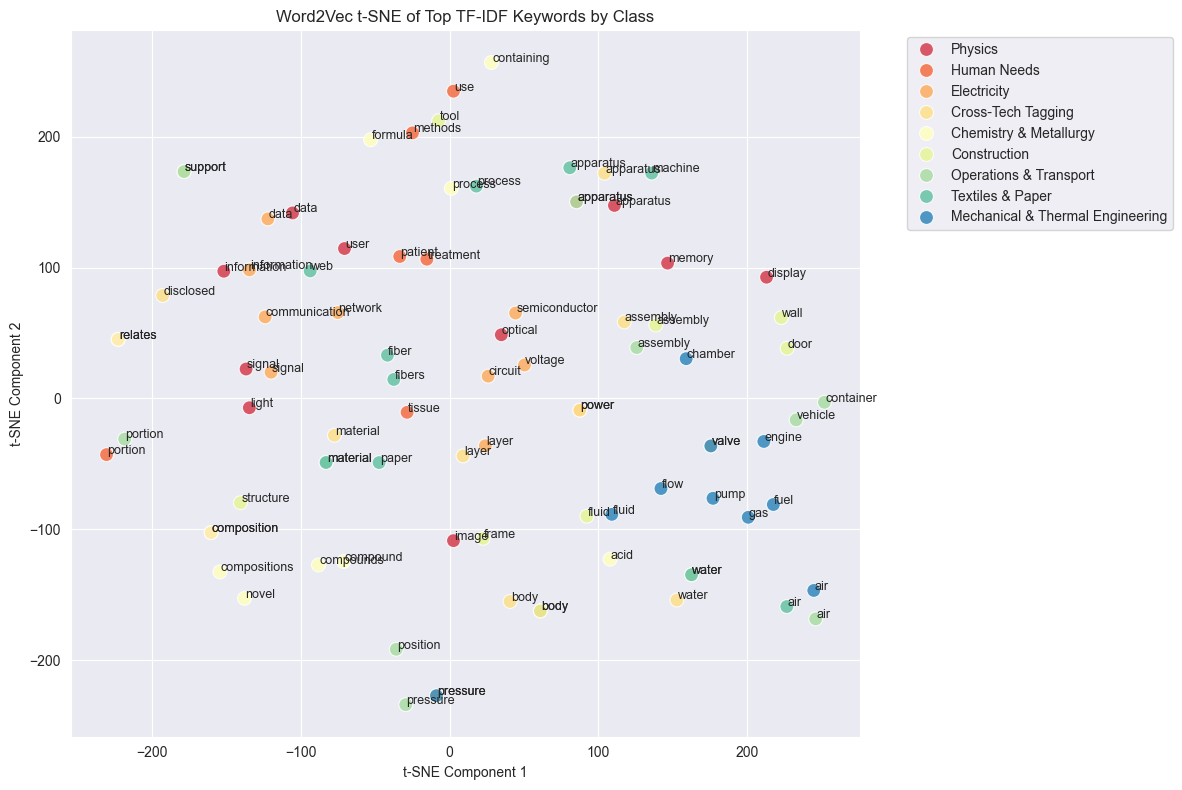

In [108]:
# --- Word2Vec Embedding and t-SNE Plot ---
print("Loading Word2Vec model...")
word2vec_model = StaticVectors("neuml/word2vec")

def get_word2vec_embedding(text: str) -> np.ndarray:
    results = []
    for word in text.split():
        embedding = word2vec_model.embeddings([word])
        if embedding is not None and len(embedding) > 0:
            results.append(embedding[0])
    if results:
        return np.mean(results, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)


embedding_data = []
for label in keywords_df.columns:
    for keyword in keywords_df[label].dropna():
        vec = get_word2vec_embedding(keyword)
        if vec is not None and not np.all(vec == 0):
            embedding_data.append({"keyword": keyword, "label": label, "embedding": vec})

embedding_df = pd.DataFrame(embedding_data)
embeddings_matrix = np.vstack(embedding_df["embedding"].values)

tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000)
reduced = tsne.fit_transform(embeddings_matrix)
embedding_df["x"] = reduced[:, 0]
embedding_df["y"] = reduced[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=embedding_df, x="x", y="y", hue="label", palette="Spectral", s=100, alpha=0.85)
for _, row in embedding_df.iterrows():
    plt.text(row["x"] + 0.5, row["y"] + 0.5, row["keyword"], fontsize=9)
plt.title("Word2Vec t-SNE of Top TF-IDF Keywords by Class")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Visualization Analysis

The term distribution across categories shows a considerable **overlap of common words** such as *air*, *data*, *water*, *portion*, *signal*, and *process*. This lexical similarity may pose challenges for the model in achieving high classification accuracy, as these shared terms reduce the discriminative power of the input features.

The **t-SNE plot** provides further insight into class separability:

* **Mechanical & Thermal Engineering** exhibits the most distinct clustering, forming a well-defined group toward the central right (blue dots), indicating strong intra-class consistency.
* In contrast, **Physics** and **Electricity** show significant overlap in the embedding space, suggesting that these categories may be easily confused by the model due to shared vocabulary and semantic similarity.

Additionally, this analysis highlights the need for improved **text normalization**. For example, both singular and plural forms like <code>fiber</code> and <code>fibers</code> appear as separate tokens, adding unnecessary variability. Applying **stemming or lemmatization** can help reduce such redundancies and improve the robustness of the vocabulary representation for classification.


## **Chi-squared (χ²)**

After identifying the most frequent and informative terms per class using TF-IDF, and visualizing them using Word2Vec embeddings and t-SNE, we gained an intuitive sense of how terms relate across categories. However, two issues emerge:

| Issue                                          | Insight                                                                                                                                                                                                    |
| ---------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Overlapping terms**                       | TF-IDF highlights frequent terms within a class, but it doesn't measure whether those terms are *unique* to that class. |
| **2. No statistical test for class relevance** | TF-IDF is a frequency-weighted scheme, but not a measure of **association strength** between terms and labels. We need a way to ask: *“Which terms are truly discriminative for this class?”*              |


The χ² statistic complements TF-IDF by **quantifying the discriminative power** of each term. Unlike TF-IDF, which rewards in-class term importance, χ² rewards **between-class contrast**.


🧪 How Chi² Feature Selection Works
For every word (feature) and label:

1. It builds a contingency table: how often the word appears with and without the label.

2. It compares the observed frequency with what would be expected if there was no relationship.

3. It returns a score — higher means the word is highly discriminative for that label.

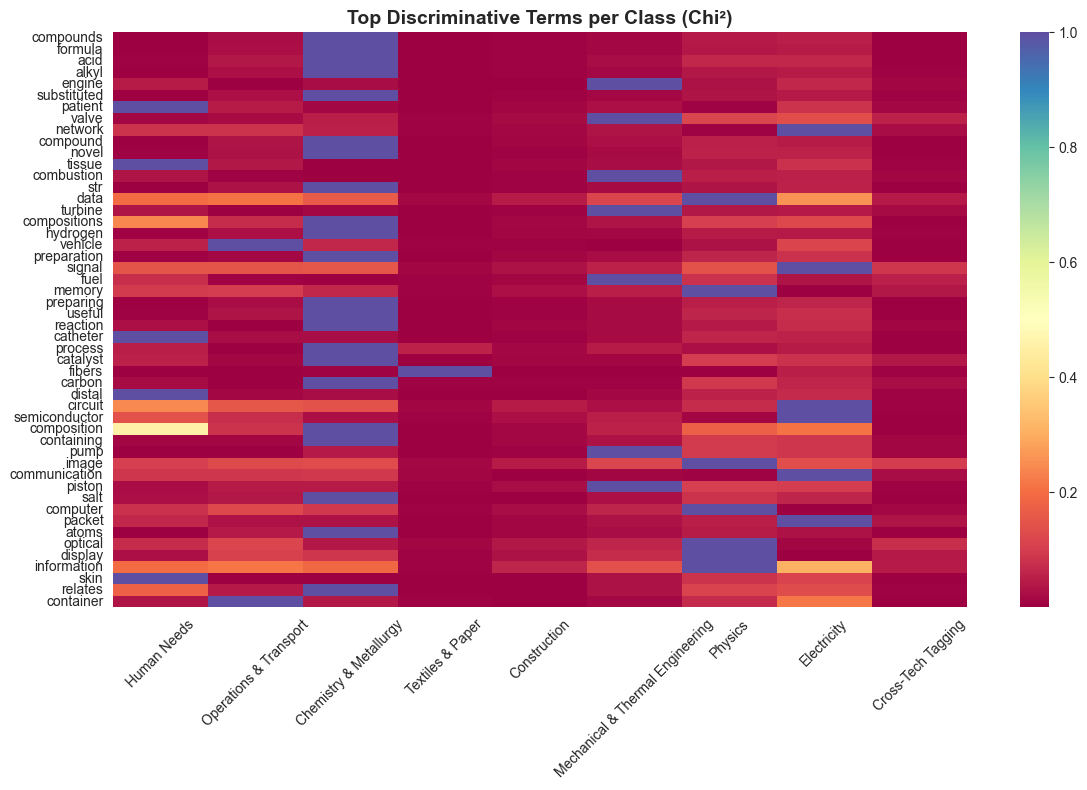

In [118]:
# --- Chi² Discriminative Terms & Heatmap ---
chi2_df = pd.DataFrame(index=features)
for class_id, class_name in label_map_int.items():
    y_binary = (y == class_id).astype(int)
    chi2_scores, _ = chi2(X, y_binary)
    chi2_df[class_name] = chi2_scores

top_terms = chi2_df.max(axis=1).sort_values(ascending=False).head(50).index
chi2_top_df = chi2_df.loc[top_terms]
chi2_normalized = chi2_top_df.div(chi2_top_df.max(axis=1), axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(chi2_normalized, cmap="Spectral", annot=False, xticklabels=True, yticklabels=True)
plt.title("Top Discriminative Terms per Class (Chi²)", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**1. Term-Class Discriminativeness**

- $\textcolor{Blue}{Dark blue}$ areas indicate high χ² values, which suggest that the term is significantly overrepresented in that class compared to others,— i.e., the term is highly discriminative for a given class.
- $\textcolor{Red}{Dark red}$ or $\textcolor{Yellow}{yellow}$ areas mean the term is less useful in distinguishing that class, i.e., the term occurs independently of the class, being equally common across all categories, so not useful for classification.

Some examples: 
    - <code>Chemistry & Metallurgy</code> has a very distriminative vocabulary associated to words like reaction, alkyl, hydrogen, acid, formula, compound, salt, carbon, atoms.
    - <code>Mechanical & Thermal Engineering</code> also has engine, valve, combustion, compressor, fuel, piston, turbine. 
    - Terms like “catheter” or “patient” are relatively exclusive to <code> Human Needs</code> , showing good discriminative potential.
    - Interesting is to note that the category <code>Cross & Tech Tagging</code> is marked by dark red, which means that no discrimative terms are found in its vocabulary.

    
**2. Shared Vocabulary Across Classes and Category Ambiguity**

- Terms like "data", "signal" that we have notived previously were shared across the classes, now are identified as stronger and highly discriminative for the category <code>Physics</code> and <code>Electricity</code> respectively.

# **3. Random Classifier Performance**
---
In this section, we calculate the expected performance of a random classifier as a baseline benchmark for our patent abstract classification task. This serves as a reference point to evaluate the effectiveness of more sophisticated models.

We implemented and evaluated the following configurations using both **TF-IDF** and **word embedding-based** representations, and considering the class imbalance and multiclass problem:


- Stemming + TF-IDF + Logistic Regression: with the aim to remove 

- TF-IDF Weighted Word2Vec Embeddings + Logistic Regression

- Word2Vec + RNN




## **Stemming + TFIDF + LogisticRegression**


1. Before applying TF-IDF, we need to clean the reviews by removing generic words patents, special characters, punctuation marks, and numbers, and converting all text to lowercase. For this, we’ll use the preprocessing functions <code>remove_generic_words_patents</code>, <code>remove_special_characters</code>, and then stemming will be applied to reduce the words to their root forms, since previously, we have noticed the presence of the same words but in different forms, like verbs in different conjunctions or sustantives in plural/singular. This consolidation lowers the dimensionality of the feature space, which is especially important in our high-dimensional settings.

2. **TF-IDF hyperparameters:** when defininf the hyperparameters, we take into account that unique words may be decisive in the patent classification process, but due to their rarity they are often discarded at the preprocessing step, so for that we dont set <code>min_df</code> hyperparameter and follow the same hyperparameters choosen in the previous section that showed reasonable results.

3. Define the logistic regression model with basic hyperparameters.

/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


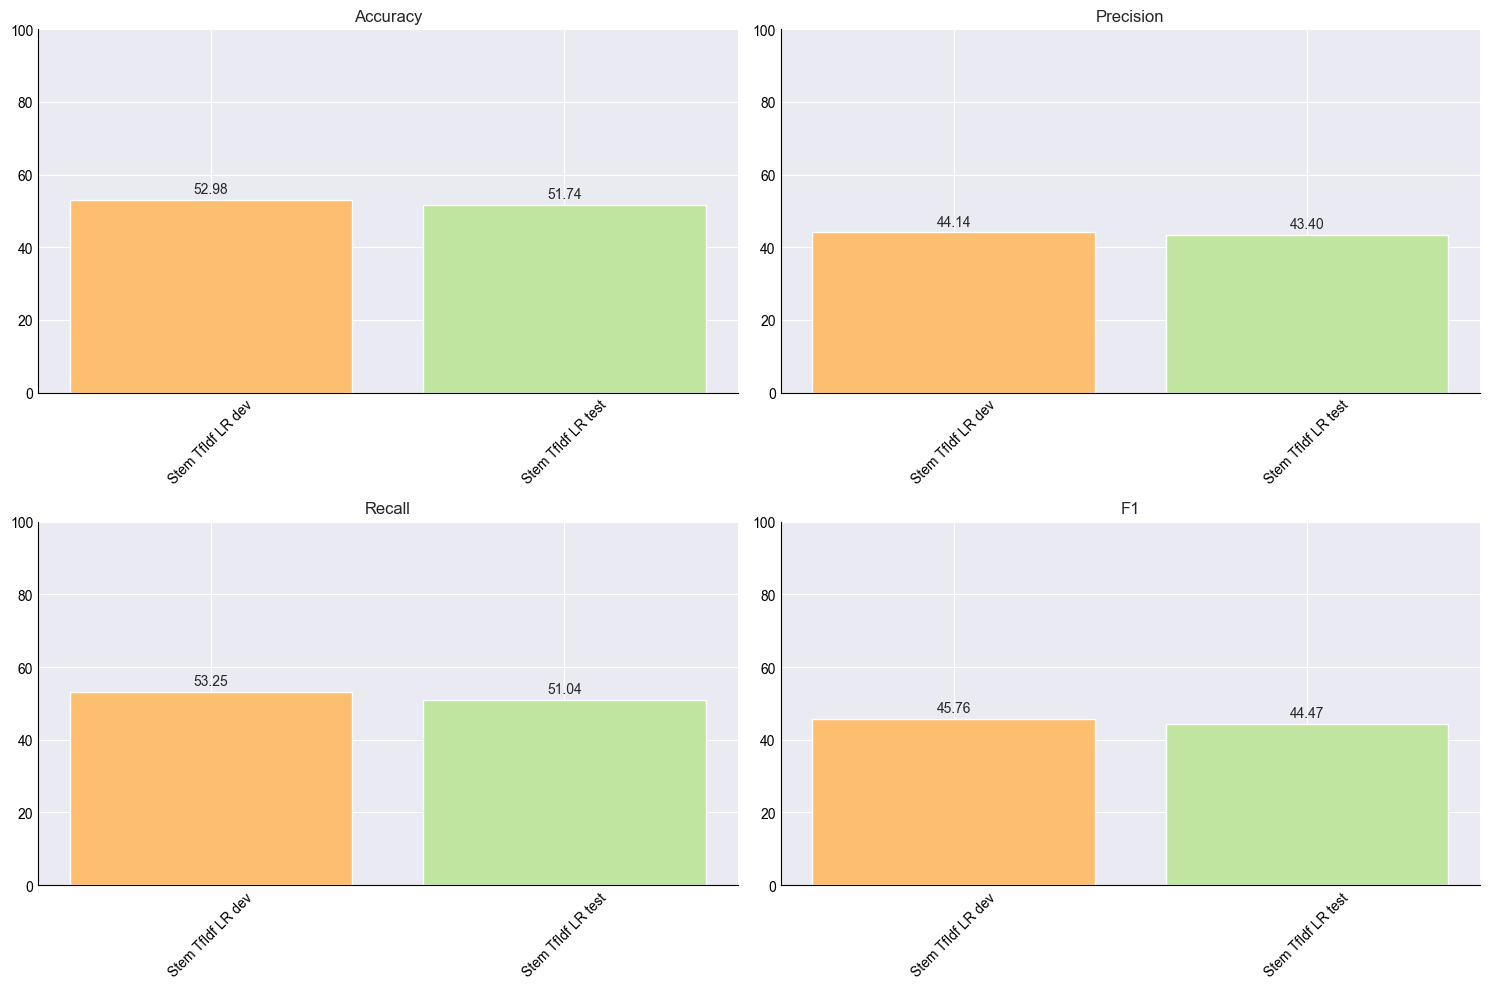

In [110]:
class StemTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return [' '.join([self.stemmer.stem(word) for word in text.split()]) for text in X]

# Set some hyperparameter settings for Tf-Idf
tfidf_params = {
    "stop_words": "english",                                          
    "max_df": 0.7,                     
    "ngram_range": (1, 2),             
    "max_features": 1000             
}

# Update pipeline to include stemming
pipeline = Pipeline([
    ('preprocessor_1', FunctionTransformer(lambda X: [remove_generic_words_patents(text) for text in X])),
    ('preprocessor_2', FunctionTransformer(lambda X: [remove_special_characters(text) for text in X])),
    ('stemmer', StemTransformer()),
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('logreg', LogisticRegression(random_state=42,
         C=1.0,
         penalty='l2',
         solver='lbfgs',
         max_iter=1000,
         class_weight='balanced',
         multi_class='multinomial'
         ))
])

#Train the model
pipeline.fit(df_train["text"], df_train["label"])

# Evaluate on dev set
y_dev_pred = pipeline.predict(df_val["text"])
y_dev_true = df_val['label']

results = Metrics()
results.run(y_dev_true, y_dev_pred, 'Stem TfIdf LR dev')

# Test on test set
y_test_pred = pipeline.predict(df_test['text'])
y_test_true = df_test['label']
results.run(y_test_true, y_test_pred, 'Stem TfIdf LR test')
results.plot()

The model shows modest performance, which highlights the complexity of the task

* **Accuracy (51.7%)**: Reflects overall correctness, but can be misleading due to class imbalance — the model may focus on predicting majority classes well while ignoring minorities.
* **Precision (43.4%)**: The model often predicts incorrect classes (many false positives).
* **Recall (51.4%)**: It recovers a fair number of true labels but still misses a substantial portion (false negatives).
* **F1 Score (44.5%)**: A balanced measure showing the model struggles to be both precise and comprehensive across all classes.


The resons that could explain this performance might be that the abstract language contains many overlapping or ambiguous terms across categories as we have seen in previous exploratory analysis, that dilute discriminative signals and TF-IDF lacks contextual understanding, treating each word as independent and ignoring semantic relationships between terms (e.g., "semiconductor" and "transistor" being treated as unrelated). 

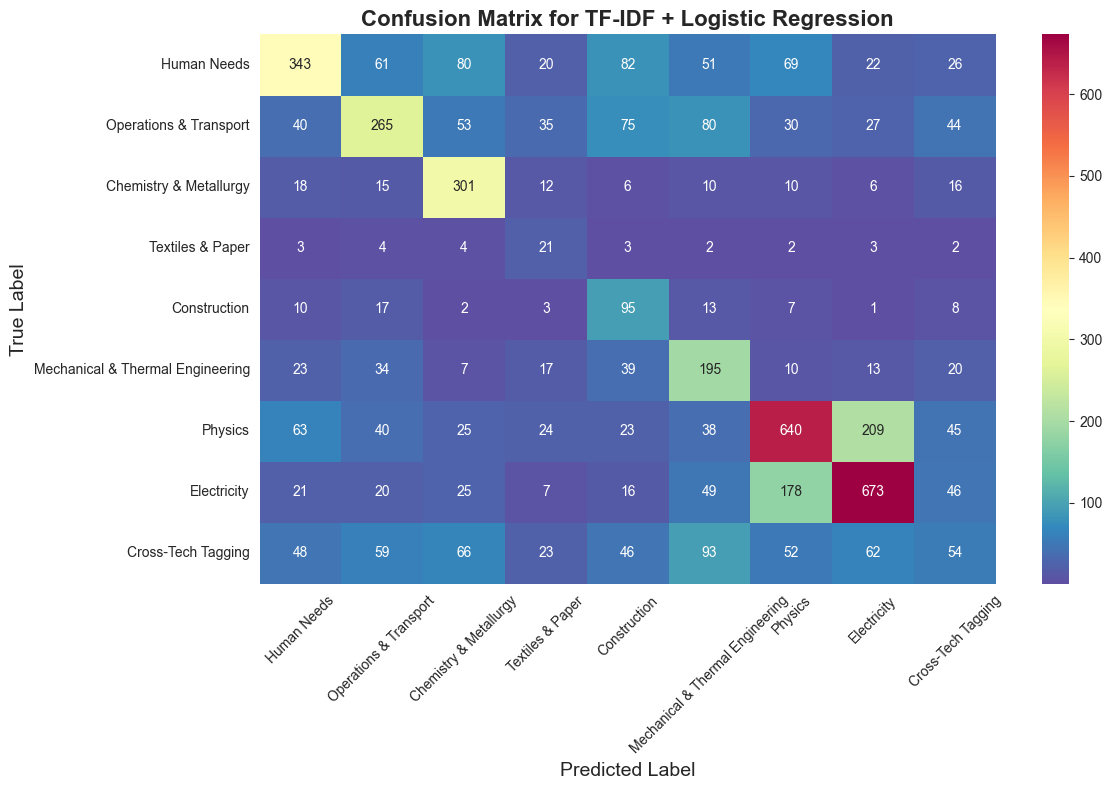

In [111]:
y_test_pred = pipeline.predict(df_test['text'])
y_test_true = df_test['label']
#map the labels to the names
label_map_int = {int(k): v for k, v in label_map.items()}

#convert predictions and true labels
y_test_true_named = [label_map_int[label] for label in y_test_true]
y_test_pred_named = [label_map_int[label] for label in y_test_pred]

#compute confusion matrix
conf_matrix = confusion_matrix(y_test_true_named, y_test_pred_named, labels=list(label_map_int.values()))

#plot
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Spectral_r',
            xticklabels=label_map_int.values(),
            yticklabels=label_map_int.values())


#add labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix for TF-IDF + Logistic Regression", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The classes that most often confuse the models are **Physics** and **Electricity**. These categories not only make up the majority of the data but also share very similar vocabulary, which makes it difficult for the model to distinguish between them accurately.

Another poorly performing category is **Cross-Tech Tagging**, which was expected. This category is likely too broad and its vocabulary lacks distinctive features, making it hard for the model to differentiate it from other classes. For instance from the Chi2 analysis, it couldn't be visible terms that really are distinctive to its vocabulary.

For categories where we have seen a very marked vocabulary, like Chemistry & Metallurgy, Mechanical & Themal Engineering, the model performs very well.

### **Feature Importance**

Since we are fitting a logistic regression model, we can use the coefficients associated to the tokens to understand which tokens drive the predictions.

- **Contribution of Each Token**: We extract the coefficient for each feature (token).

- **Ranking Top Tokens**: We rank tokens for each patent class.


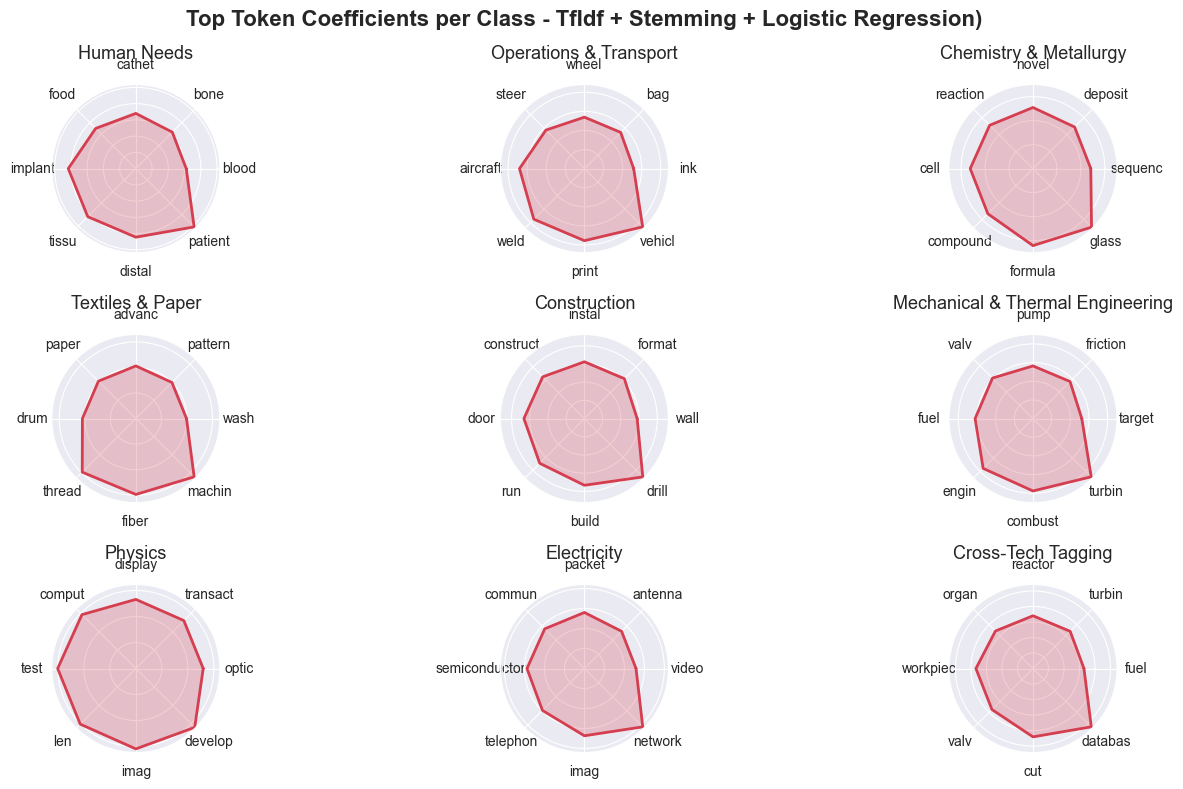

In [112]:
# Get trained components
logreg = pipeline.named_steps['logreg']
tfidf = pipeline.named_steps['tfidf']

# Get feature names and model coefficients
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = logreg.coef_  # shape: (n_classes, n_features)

# Number of top tokens per class to visualize
top_n = 8
num_classes = coefficients.shape[0]
class_labels = [label_map.get(str(i), str(i)) for i in range(num_classes)]

# Set up radar plot
fig, axes = plt.subplots(nrows=3, ncols=3, subplot_kw={'projection': 'polar'}, figsize=(14, 8))
axes = axes.flatten()

for i, ax in enumerate(axes[:num_classes]):
    class_coef = coefficients[i]
    top_indices = np.argsort(class_coef)[-top_n:]
    top_tokens = feature_names[top_indices]
    top_values = class_coef[top_indices]

    # Radar plot needs circular data, so close the loop
    angles = np.linspace(0, 2 * np.pi, top_n, endpoint=False).tolist()
    angles += angles[:1]
    values = top_values.tolist()
    values += values[:1]
    labels = top_tokens.tolist()
    labels += labels[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', color='#d53e4f')
    ax.fill(angles, values, alpha=0.25, color='#d53e4f')
    ax.set_title(class_labels[i], size=13, y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(top_tokens, fontsize=10)
    ax.set_yticklabels([])

plt.suptitle("Top Token Coefficients per Class - TfIdf + Stemming + Logistic Regression)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


From this plot we can see that in general the model used preetty much the same words that we have identified as discriminative terms in the vocabulary of each class, confirming our direction.

It is relevant to notice that for the category Chemistry and Metallurgy the top 8 tokes used to make the prediction are slight different from what we observed in the Chi2 and TFIDF methods applied in the Dataset Description section, where the terms are not that related to chemistry like acid, mixture, ethyl, sodium, chloride, methanol, but still the terms are related to the vocabulary industry.

## **TFIDF Word2Vev + LogisticRegression**

To explore semantic representations beyond sparse TF-IDF vectors, we leveraged pre-trained Word2Vec embeddings from the Google News dataset to encode patent texts at the sentence level. 

To account for word importance, we weighted each word vector by its TF-IDF score, assigning higher relevance to rarer but potentially more discriminative terms. 

This approach will be able to downweight neutral or frequent words, and focus on the discriminative terms that might be the ones that are decisive in the patent classification process.

Loading Word2Vec model...


/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


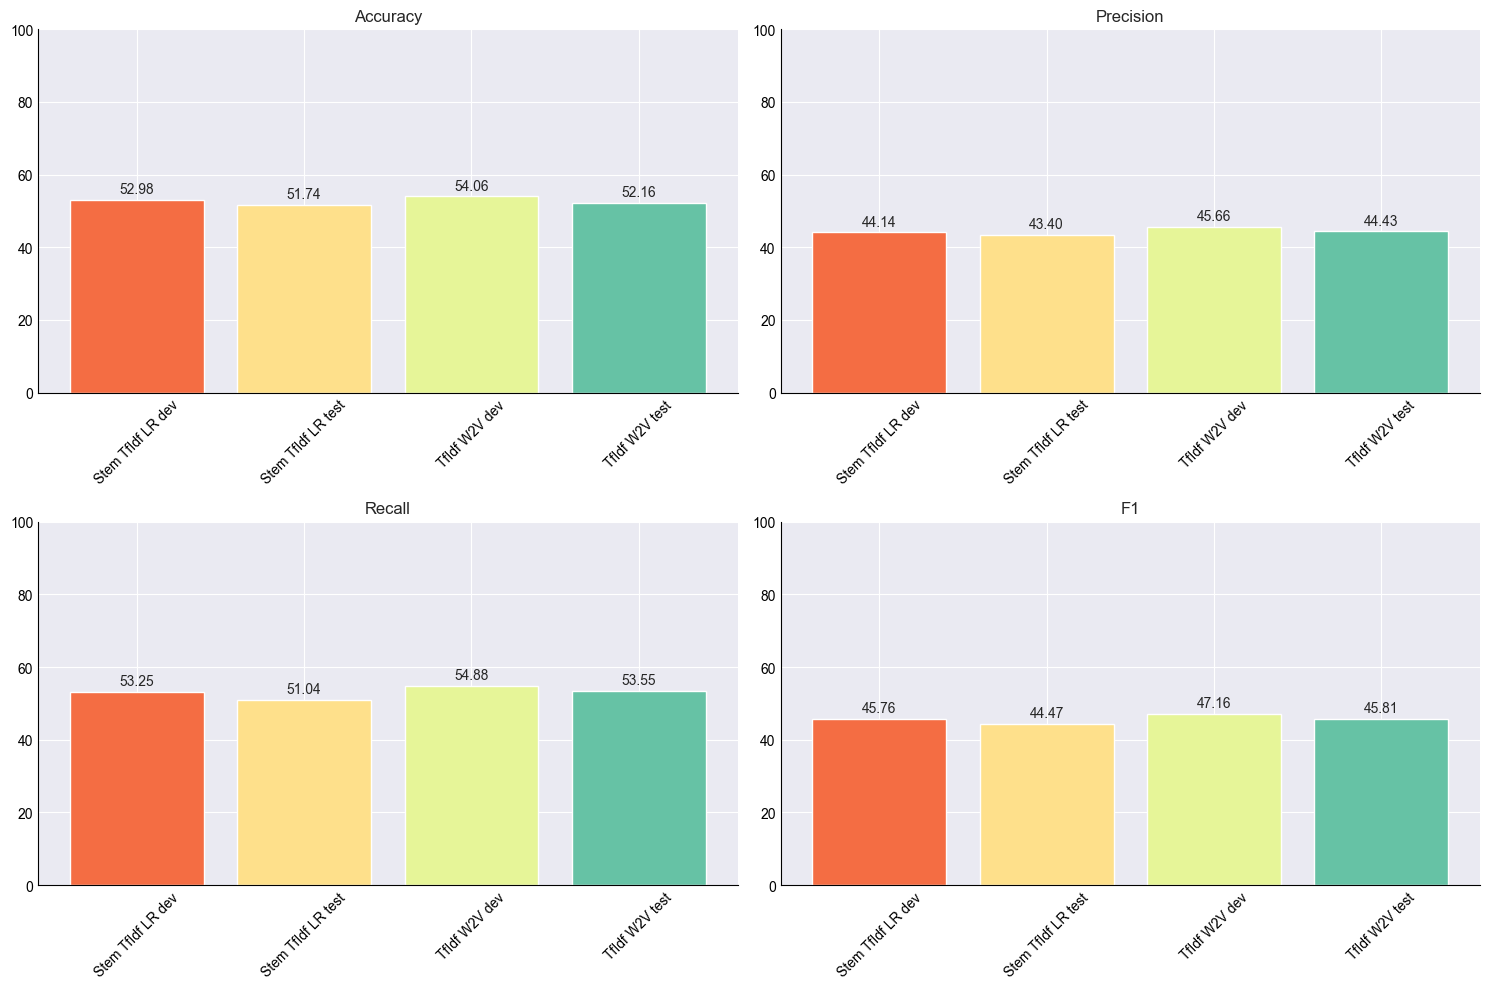

In [113]:
# Load StaticVectors model
print("Loading Word2Vec model...")
word2vec_model = StaticVectors("neuml/word2vec")

class TfidfEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model
        self.tfidf = TfidfVectorizer(max_df=0.7, ngram_range=(1,2), max_features=1000, stop_words='english')
        self.word2weight = {}

    def fit(self, X, y=None):
        self.tfidf.fit(X)
        max_idf = max(self.tfidf.idf_)
        self.word2weight = {word: self.tfidf.idf_[i]
                            for word, i in self.tfidf.vocabulary_.items()}
        self.max_idf = max_idf
        return self

    def transform(self, X):
        features = []
        for i, text in enumerate(X):
            words = text.split()
            word_vecs = []
            weights = []
            for word in words:
                vec = self.word2vec_model.embeddings([word])
                if vec is not None and len(vec) > 0:
                    weight = self.word2weight.get(word, self.max_idf)
                    word_vecs.append(vec[0])
                    weights.append(weight)
            if word_vecs:
                word_vecs = np.array(word_vecs)
                weights = np.array(weights)
                weighted_avg = np.average(word_vecs, axis=0, weights=weights)
            else:
                weighted_avg = np.zeros(self.word2vec_model.vector_size)
            features.append(weighted_avg)
        return np.array(features)


# TF-IDF weighted pipeline
tfidf_w2v_pipeline = Pipeline([
    ('preprocessor_1', FunctionTransformer(lambda X: [remove_generic_words_patents(text) for text in X])),
    ('preprocessor_2', FunctionTransformer(lambda X: [remove_special_characters(text) for text in X])),
    ("tfidf_w2v", TfidfEmbeddingVectorizer(word2vec_model)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', multi_class='multinomial', C=1.0, penalty='l2', solver='lbfgs'))
])

# Fit model
tfidf_w2v_pipeline.fit(df_train['text'], df_train['label'])

# Predict
y_pred_tfidfw2v_dev = tfidf_w2v_pipeline.predict(df_val['text'])
y_pred_tfidfw2v_test = tfidf_w2v_pipeline.predict(df_test['text'])

# Evaluate
results.run(df_val['label'], y_pred_tfidfw2v_dev, "TfIdf W2V dev")
results.run(df_test['label'], y_pred_tfidfw2v_test, "TfIdf W2V test")
results.plot()

## **Word2Vec  + RNN**

In this section, we combine **pretrained Word2Vec embeddings** with a **RNN** using **LSTM units**. While Word2Vec captures the **meaning** of individual words, LSTMs allow the model to learn the **order** and **context** in which those words appear — essential for understanding sentiment in full reviews.

### Tokenizer and Padding and Trucating Sequences

We set <code>vocab_size = 15,000</code> to retain a broad and expressive vocabulary, capturing the technical language often found in patents. We chose <code>max_length = 200</code> to preserve meaningful content, based on the observed distribution of document lengths. This ensures that most documents are processed without excessive truncation while maintaining stable RNN training.

In [114]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Parameters
vocab_size = 15000  # Number of words to keep
max_length = 200    # Max length of a patent abstract (in words)

train_texts = df_train['text'].to_list()
dev_texts = df_val['text'].to_list()
test_texts = df_test['text'].to_list()

y_train = df_train['label'].to_list()
y_dev = df_val['label'].to_list()
y_test = df_test['label'].to_list()

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_texts)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

#Padding and Trucating Sequences
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_length,padding='post', truncating='post')
dev_sequences_padded = pad_sequences(dev_sequences, maxlen=max_length,padding='post', truncating='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length,padding='post', truncating='post')

num_classes = len(set(y_train))
train_labels_lstm = to_categorical(y_train, num_classes= num_classes)
dev_labels_lstm = to_categorical(y_dev, num_classes= num_classes)

# Compute class weights using original class indices
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

# Convert to dictionary format expected by Keras
class_weights_dict = dict(enumerate(class_weights))

### Word2Vec Embeddings

In [115]:
word2vec_model = StaticVectors("neuml/word2vec")
# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tqdm(tokenizer.word_index.items()):
    if i < vocab_size:
        try:
            embedding_vector = word2vec_model.embeddings([word])
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Word not found in the model, leave as zeros
            continue

100%|██████████| 37073/37073 [00:00<00:00, 204639.91it/s]


### LSTM Model

In [116]:
# Define the model
model_ft = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 300, weights=[embedding_matrix],
              input_length=max_length, trainable=True),  

    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(32)),  
    Dense(num_classes, activation='softmax')  
])

model_ft.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Setup early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # How many epochs to wait after min has been hit
    verbose=1,  # Verbosity level
    mode='min',  # Mode for the monitored quantity (minimizing loss)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model_ft.fit(
    train_sequences_padded,
    train_labels_lstm,
    validation_data = (dev_sequences_padded, dev_labels_lstm),
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 51s 252ms/step - accuracy: 0.2957 - loss: 1.9255 - precision_1: 0.5143 - recall_1: 0.0343 - val_accuracy: 0.5056 - val_loss: 1.4122 - val_precision_1: 0.7013 - val_recall_1: 0.2752
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 265ms/step - accuracy: 0.5833 - loss: 1.1642 - precision_1: 0.7108 - recall_1: 0.4247 - val_accuracy: 0.5630 - val_loss: 1.3187 - val_precision_1: 0.6618 - val_recall_1: 0.4312
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 265ms/step - accuracy: 0.6905 - loss: 0.8515 - precision_1: 0.7743 - recall_1: 0.5925 - val_accuracy: 0.5932 - val_loss: 1.2668 - val_precision_1: 0.6615 - val_recall_1: 0.5136
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 264ms/step - accuracy: 0.7616 - loss: 0.6438 - precision_1: 0.8272 - recall_1: 0.6912 - val_accuracy: 0.5798 - val_loss: 1.3671 - val_precision_1: 0.6377 - val_recall_1: 0.5302
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 266ms/step - accuracy: 0.8120 - loss: 0.5027 - precision_1: 0.8567 - rec

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


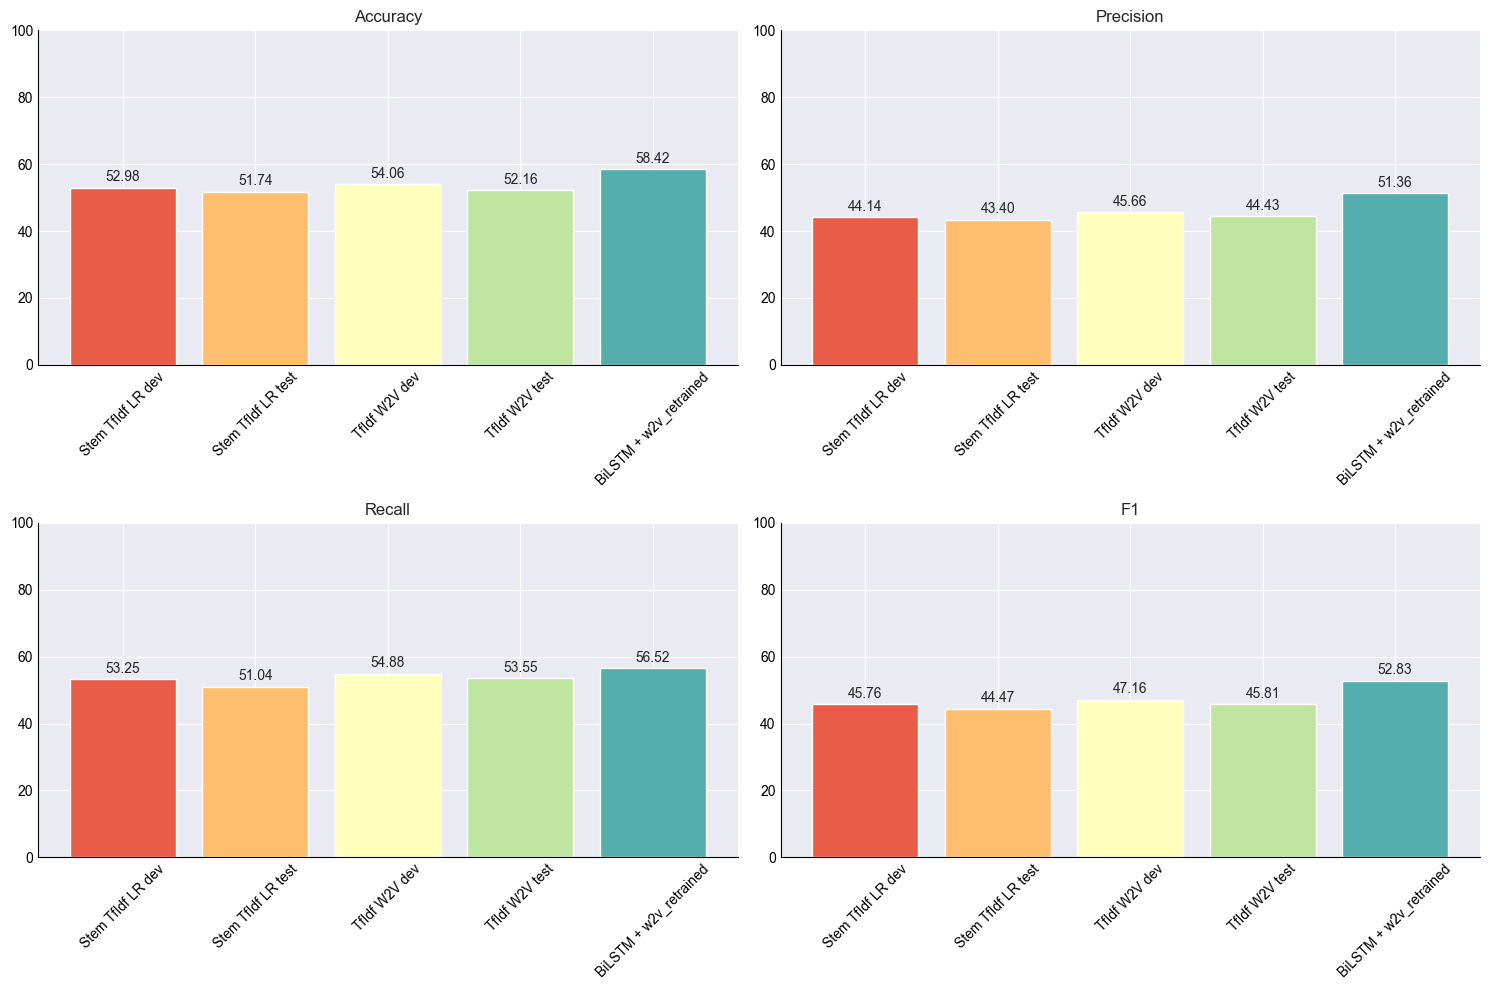

In [117]:
y_test_pred = model_ft.predict(test_sequences_padded)
y_test_pred = np.argmax(y_test_pred, axis=1)
results.run(y_test, y_test_pred, "BiLSTM + w2v_retrained")
results.plot()

## **Results and Discussion**

We evaluated multiple text representation techniques combined with Logistic Regression for the task of multi-class patent classification across 9 categories. The approaches tested include:

- **Stemming + TF-IDF + Logistic Regression**
- **TF-IDF-weighted Word2Vec + Logistic Regression**
- **Word2Vec + RNN**

The results align well with the expected trade-off between model complexity and performance. As the models incorporate deeper semantic representation and contextual information, we observe incremental improvements in classification effectiveness.

- The **baseline model**—**Stemming + TF-IDF + Logistic Regression**—offers a strong foundation, performing well due to its ability to capture keyword frequency and term importance, especially when enhanced with preprocessing steps like stemming and stopword removal.

- Building upon this, **TF-IDF-weighted Word2Vec + Logistic Regression** introduces dense embeddings that bring in semantic similarity between terms. This approach slightly improves performance by capturing word-level meaning, although it remains limited by the use of static, non-contextual embeddings.

- Finally, **Word2Vec + RNN** further improves performance, as the RNN adds sequential modeling capacity, enabling the model to understand some level of contextual flow in abstracts. However, the gains are modest compared to the SOA, likely due to the **domain mismatch** of pretrained Word2Vec embeddings not being tailored to patent language.

This progression confirms that **each added layer of linguistic complexity contributes to better performance**, and suggests that moving toward **contextual embedding models**—such as **BERT**—is a promising direction. These models use self-attention mechanisms to generate **context-aware token representations**, allowing them to capture nuanced meaning, handle vocabulary ambiguity, and scale to longer sequences more effectively.


# **4. Baseline Implementation**
---
Nowadays, the patents still have to be labeled by domain experts with one or many of thousands of categories. This process is not only extremely expensive but also overwhelming for the experts, due to the considerable increase of filed patents over the years.


In this last section, we will develop a rule-based classifier as a baseline, where we will discuss its performance in the context of the dataset's complexity.

Since the word clouds showed that patent texts are dominated by generic words and structural terms related to patents, we remove these to reduce the vocabulary size, making it easier to build an effective rule-based classifier.

In [119]:
# Get the stop words set from previous EDA process
stop_words_set = stop_words.union(generic_words_patents)

# Clean and tokenize the text column
df_train['text'] = df_train['text'].apply(lambda x: ' '.join(get_clean_tokens_list([x], stop_words_set)))
df_val['text'] = df_val['text'].apply(lambda x: ' '.join(get_clean_tokens_list([x], stop_words_set)))
df_test['text'] = df_test['text'].apply(lambda x: ' '.join(get_clean_tokens_list([x], stop_words_set)))

### Step 1

Calculate the relative frequency of the most important words for each label. This helps identify **class-specific keywords**—words that appear more frequently in one category than others (e.g., "force" in *Physics* vs. "voltage" in *Electricity*).

Unlike `CountVectorizer`, which computes token frequencies across the entire dataset without considering class labels, this approach analyzes word usage **within each class**. This makes it more suitable for our rule-based classifiers, where distinguishing terms per category is essential.

In [120]:
#create and empty dictionary to store the keywords and its frequency for each class
keywords_per_class = {}
for cat in df_train['label_name'].unique():
    texts = df_train[df_train['label_name'] == cat]['text'].values
    tokens = get_clean_tokens_list(texts, {})
    tokens = [token for token in tokens if token not in set(spacy_stopwords) and len(token) > 2]
    token_freq = dict(Counter(tokens))
    sum_tokens = sum(token_freq.values())
    #calculate the inverse token frequency
    token_freq = {k: (v/sum_tokens) for k, v in token_freq.items()}
    keywords_per_class[cat] = token_freq

### Step 2

We clean the `keywords_per_class` dictionary by removing words that are either too common across classes or too rare within them.


- **Remove generic terms**: Words that appear in all classes with high frequency (e.g., > 0.01), like *"data"* or *"system"*, are not helpful for distinguishing categories and can weaken regex precision.

- **Remove noisy terms**: Very low-frequency words (e.g., < 0.0005) may be typos or overly specific, leading to fragile or irrelevant rules.

- **Focus on class-specific tokens**: Keeping only moderately frequent, unique words helps generate clearer and more effective regex patterns.

#### ⚙️ What It Does

1. Finds words shared across all classes.
2. Removes shared words that are either too frequent or too rare.
3. Keeps only the most relevant keywords for each class.

This ensures cleaner, more discriminative inputs for building accurate and interpretable regex rules.

In [121]:
#from keywords_per_class, remove those common between keys whose values are bigger than 0.01
join_words = {}
for cat, words in keywords_per_class.items():
    if len(join_words) == 0:
        join_words = set(words.keys())
    else:
        join_words = join_words.intersection(set(words.keys()))

for cat, words in keywords_per_class.items():
    words_to_remove = []
    for word, word_val in words.items():
        if word in join_words and (word_val > 0.01 or word_val < 0.0005):
            words_to_remove.append(word)
    for word in words_to_remove:
        keywords_per_class[cat].pop(word)


### Step 3

Construct a feature-based dataset using the cleaned keyword lists.

This step scores each text sample against the class-specific keywords extracted earlier. For every document, it:

- Computes a **score per class** by summing the product of token frequency in the text and its corresponding weight in `keywords_per_class`.
- Trims the last 25% of the text to simulate partial input, helping the classifier rely on early-occurring keywords, based on the idea that the beggining of the patent document can contain great part of the relevant information of the patent.
The result is a new dataset where each row represents a document with class-wise scores and useful features for rule-based classification.

> 🆚 Compared to standard vectorization methods like `CountVectorizer`, this method produces **class-aware, interpretable features**.


In [122]:
def construct_dataset(df_train, keywords_per_class, min_freq=0, max_freq=1):
    dataset = []
    
    for i in range(len(df_train)):
        true_class = int(df_train.label.iloc[i])
        text_id = i
        str_len = len(df_train.text.iloc[i])
        text = df_train.text.iloc[i].split()
        text = text[:round(len(text)*0.75)]
        text_clean_tokens = get_clean_tokens_list(text, set(spacy_stopwords))
        text_token_freq = dict(Counter(text_clean_tokens))

        row_data = {}
        for cat, words in keywords_per_class.items():
            score = 0
            for word, freq in text_token_freq.items():
                if word in words:
                    score += freq * words[word]
            row_data[cat] = score

        # Add additional metadata
        row_data["true_class"] = true_class
        row_data["text_id"] = text_id

        dataset.append(row_data)

    df_new = pd.DataFrame(dataset)
    return df_new


new_df_train = construct_dataset(df_train, keywords_per_class)
new_df_dev = construct_dataset(df_val, keywords_per_class)
new_df_test = construct_dataset(df_test, keywords_per_class)
new_df_train.head()

,Physics,Human Needs,Electricity,Cross-Tech Tagging,Chemistry & Metallurgy,Construction,Operations & Transport,Textiles & Paper,Mechanical & Thermal Engineering,true_class,text_id
0,0.125889,0.025471,0.166406,0.066609,0.019830,0.025338,0.039265,0.030172,0.054248,6,0
1,0.020566,0.058536,0.030372,0.055918,0.002678,0.083871,0.062796,0.046270,0.091693,0,1
2,0.020804,0.012579,0.054614,0.020602,0.002377,0.010340,0.010766,0.006844,0.009295,7,2
3,0.017100,0.028830,0.015960,0.018052,0.042144,0.013437,0.014615,0.014748,0.012923,0,3
4,0.017870,0.027506,0.014438,0.029314,0.019798,0.041052,0.033937,0.030557,0.050589,8,4


### Step 4

In this step, we implement and evaluate the **rule-based classifier** using the dataset previously built, where each category is assigned a score based on keyword overlap.

The rule simply assigns each patent to the category with the highest score. These scores reflect how much the patent shares vocabulary with each class's training data, after preprocessing steps like removing stopwords, rare and overly common words.

In [123]:
cols = ["Human Needs", "Operations & Transport", "Chemistry & Metallurgy", "Textiles & Paper", "Construction", "Mechanical & Thermal Engineering", "Physics", "Electricity", "Cross-Tech Tagging"]
X_train = new_df_train[cols]
X_val = new_df_dev[cols]
X_test = new_df_test[cols]

y_train = new_df_train["true_class"]
y_val = new_df_dev["true_class"]
y_test = new_df_test["true_class"]

In [124]:
# Rule base classifier. The category with the highest score is the predicted category.
y_train_pred = np.argmax(X_train, axis=1)
y_val_pred = np.argmax(X_val, axis=1)
y_test_pred = np.argmax(X_test, axis=1)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=list(label_map.values())))

                                  precision    recall  f1-score   support

                     Human Needs       0.73      0.14      0.24       754
          Operations & Transport       0.50      0.21      0.29       649
          Chemistry & Metallurgy       0.43      0.86      0.58       394
                Textiles & Paper       0.11      0.61      0.18        44
                    Construction       0.16      0.63      0.25       156
Mechanical & Thermal Engineering       0.28      0.65      0.39       358
                         Physics       0.56      0.42      0.48      1107
                     Electricity       0.52      0.62      0.57      1035
              Cross-Tech Tagging       0.20      0.01      0.01       503

                        accuracy                           0.41      5000
                       macro avg       0.39      0.46      0.33      5000
                    weighted avg       0.49      0.41      0.38      5000



As a basic rule-based approach, the classifier achieves decent performance given the simplicity of the method and the observed complexity of the patents data.

Overall, the weighted F1 score reaches around 38%. Notably, the model fails to identify any instances of the "Cross-Tech Tagging" class (zero recall and f1), while achieving high recall and precision for "Chemistry & Metallurgy", one the classes with more discriminative terms, and good performance for the dominant classes, "Electricity" and  "Physics"— which is expected due to class imbalance.

However, compared to a random classifier, the rule-based method performs worse, with an F1 score of approximately 38% versus 52% for the random baseline. This could be thought as the human way of  (counting relevant words and assigning a category)